# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.model_selection import train_test_split

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    median_absolute_error
    )

# ML algorithms
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# df = pd.read_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv')
df_total = pd.read_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv')
# RUL_additional = pd.read_csv(f'outputs/datasets/transformed/dfRulAdditional.csv') # extra available RUL calculations
# df_total_model = (pd.read_csv('outputs/datasets/transformed/dfTransformedTotal.csv')
#         .drop(labels=['4point_EWM', 'change_DP', 'change_EWM'], axis=1)
#     )
# df_train_even_dist = (pd.read_csv(f'outputs/datasets/transformed/dfTransformedTrain.csv')
#         .drop(labels=['4point_EWM', 'change_DP', 'change_EWM', 'std_DP', 'median_DP', 'bin_size'], axis=1)
#     )
# print(df_total.shape, '= df_total')
# print(df.shape, '= df')
# print(df_total_model.shape, '= df_total_model')
# print(df_train_even_dist.shape, '= df_train_even_dist')
n = df_total['Data_No'].iloc[0:len(df_total)]
df_train = df_total[n < 51].reset_index(drop=True) # larger dataset
df_test = df_total[n > 50].reset_index(drop=True)
df_total


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,39.4,0.000000,0.327257,0.242340,13.328682,44.9,99.74
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,39.3,0.000000,0.196354,0.242340,13.571021,44.9,99.74
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,39.2,0.000000,0.117813,0.242340,13.813361,44.9,99.74
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,39.1,1.808449,0.794067,0.242340,14.055701,44.9,99.44
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,39.0,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
69682,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
69683,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
69684,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


Extract bins that reach **600 pa** of differential pressure or more in **df_train** dataset

In [6]:
dp_total = df_train['Differential_pressure'].map(float).round(decimals=4)
df_train['Differential_pressure'] = dp_total
n = df_train['Differential_pressure'][0:len(df_train)]
df_train_dp = df_train[n >= 600].reset_index(drop=True)
RUL_extract = df_train_dp['Data_No']
RUL_additional = df_train.loc[df_train['Data_No'].isin(RUL_extract)]
RUL_additional

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
8821,11,14.3772,14.377170,2.665642,57.083999,0.1,158.492533,0.9,62.2,14.37717,14.377170,0.142643,0.142643,62.3,97.60
8822,11,13.1113,13.870806,2.629786,56.964773,0.2,158.492533,0.9,62.1,-1.26591,-0.506364,0.142643,0.285287,62.3,97.81
8823,11,15.0101,14.326536,2.662113,57.093926,0.3,158.492533,0.9,62.0,1.89887,0.455730,0.142643,0.427930,62.3,97.50
8824,11,16.2760,15.106337,2.715114,57.252899,0.4,158.492533,0.9,61.9,1.26591,0.779802,0.142643,0.570573,62.3,97.29
8825,11,16.1856,15.538050,2.743292,57.153539,0.5,158.492533,0.9,61.8,-0.09042,0.431713,0.142643,0.713216,62.3,97.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32279,47,594.5276,588.377825,6.377369,59.103897,104.2,79.246266,0.9,0.4,4.34020,4.099850,0.071322,74.317149,104.6,0.91
32280,47,596.4265,591.597295,6.382826,59.377463,104.3,79.246266,0.9,0.3,1.89890,3.219470,0.071322,74.388470,104.6,0.60
32281,47,598.3254,594.288537,6.387365,59.281707,104.4,79.246266,0.9,0.2,1.89890,2.691242,0.071322,74.459792,104.6,0.28
32282,47,599.6817,596.445802,6.390988,58.996220,104.5,79.246266,0.9,0.1,1.35630,2.157265,0.071322,74.531113,104.6,0.05


Include **additional RUL** variables that have a fully completed test cycle to **increase the total data in the modelling dataframe**
Remove NaN Values

In [7]:
# n = df_total['Data_No'].iloc[0:len(df_total)]
# df_train = df_total[n < 51].reset_index(drop=True) # larger dataset
# df_test = df_total[n > 50].reset_index(drop=True)
df = pd.concat([df_test, RUL_additional], ignore_index=True)

print(df_train.shape, '= df_train')
print(df_test.shape, '= df_test')
print(df.shape, '= df')
df.sort_values('Data_No', ascending=True)

(33324, 15) = df_train
(36362, 15) = df_test
(40112, 15) = df


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
36362,11,14.37720,14.377170,2.665642,57.083999,0.1,158.492533,0.9,62.2,14.37717,14.377170,0.142643,0.142643,62.3,97.60
36774,11,256.52850,259.896386,5.560283,57.558630,41.3,158.492533,0.9,21.0,-7.50510,-2.245258,0.142643,58.911674,62.3,57.25
36775,11,258.42740,259.308792,5.558020,57.723242,41.4,158.492533,0.9,20.9,1.89890,-0.587595,0.142643,59.054318,62.3,56.93
36776,11,260.32620,259.715755,5.559588,57.481806,41.5,158.492533,0.9,20.8,1.89880,0.406963,0.142643,59.196961,62.3,56.61
36777,11,264.03360,261.442893,5.566216,57.448899,41.6,158.492533,0.9,20.7,3.70740,1.727138,0.142643,59.339604,62.3,55.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36059,100,35.71687,34.417504,3.538565,82.979898,22.2,316.985065,1.2,38.0,0.18085,0.866244,0.380382,84.444821,52.4,94.05
36058,100,35.53602,33.551260,3.513074,82.937616,22.1,316.985065,1.2,38.1,1.71802,1.323173,0.380382,84.064439,52.4,94.08
36057,100,33.81800,32.228087,3.472838,82.717792,22.0,316.985065,1.2,38.2,1.26592,1.059942,0.380382,83.684057,52.4,94.36
36068,100,36.98278,36.914036,3.608592,82.650156,23.1,316.985065,1.2,37.1,1.26591,0.045829,0.380382,87.868260,52.4,93.84


# MP Pipeline: Regressor

## Create ML pipeline

The target and all requirements are already in a numerical format (float and integer)

In [8]:


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=['Data_No', '4point_EWM', 'log_EWM',
        #                                                         'Flow_rate', 'Time', 'Dust_feed', 'Dust', 'RUL',
        #                                                         'change_DP', 'change_EWM', 'mass_g',
        #                                                         'cumulative_mass_g', 'Tt','filter_balance'])),

        # ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        #  method="spearman", threshold=0.6, selection_method="variance")),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Data_No', 'Differential_pressure', '4point_EWM', 'log_EWM',
                                                                'Flow_rate', 'Time', 'Dust_feed', 'Dust',
                                                                'change_DP', 'change_EWM', 'mass_g',
                                                                'cumulative_mass_g', 'Tt','filter_balance'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [9]:
# from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score (R²)'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score (R²)': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score (R²)', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [10]:
# from sklearn.model_selection import train_test_split

X_working, X_test, y_working, y_test = train_test_split(
    # df.drop(['Differential_pressure'], axis=1),
    df.drop(['RUL'], axis=1),
    # df['Differential_pressure'],
    df['RUL'],
    test_size=0.25,
    random_state=8,
    shuffle=True
)

X_train, X_validate, y_train, y_validate = train_test_split(
    # df.drop(['Differential_pressure'], axis=1),
    # df.drop(['RUL'], axis=1),
    X_working,
    # df['Differential_pressure'],
    # df['RUL'],
    y_working,
    test_size=0.25,
    random_state=8,
    shuffle=True
)

print('\n', X_train.shape, y_train.shape, '= Train set\n',
      X_validate.shape, y_validate.shape, '= Validate set\n',
      X_test.shape, y_test.shape, '= Test set\n',
      '===========\n',
      df.shape[0], '= Total Observations\n')



 (22563, 14) (22563,) = Train set
 (7521, 14) (7521,) = Validate set
 (10028, 14) (10028,) = Test set
 40112 = Total Observations



In [11]:
X_train

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
24462,79,133.734800,134.331774,4.900313,81.043738,186.8,59.107236,1.200,-1.26590,-0.397982,0.070929,132.494780,258.1,77.71
3544,58,10.760270,10.869038,2.385918,58.458498,21.6,158.492533,1.025,0.00000,-0.072512,0.162455,35.090247,114.5,98.21
35991,100,10.579430,10.427003,2.344399,82.624780,15.4,316.985065,1.200,0.00000,0.101618,0.380382,58.578840,52.4,98.24
14097,68,132.468900,132.970680,4.890129,81.551023,140.9,59.107236,1.025,-1.26590,-0.334520,0.060585,85.364148,257.9,77.92
21472,78,50.636570,48.466935,3.880882,83.137331,103.5,59.107236,1.200,2.89352,1.446423,0.070929,73.411187,243.8,91.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15672,69,37.073210,39.693105,3.681177,81.483387,41.2,59.107236,0.900,-4.34027,-1.746596,0.053197,21.916963,145.7,93.82
20659,78,2.260561,1.741581,0.554793,82.548697,22.2,59.107236,1.200,0.00000,0.345987,0.070929,15.746168,243.8,99.62
7457,63,7.414641,7.121340,1.963096,58.151218,48.0,79.246266,1.025,0.00000,0.195534,0.081227,38.989163,115.1,98.76
24256,79,100.368900,100.519461,4.610351,81.491846,166.2,59.107236,1.200,0.00000,-0.100374,0.070929,117.883471,258.1,83.27


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [12]:
models_quick_search = {
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    'LinearRegression': LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "SGDRegressor": SGDRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "AdaBoostRegressor": {},
    "DecisionTreeRegressor": {},
    "ExtraTreesRegressor": {},
    "GradientBoostingRegressor": {},
    'LinearRegression': {},
    "RandomForestRegressor": {},
    "SGDRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

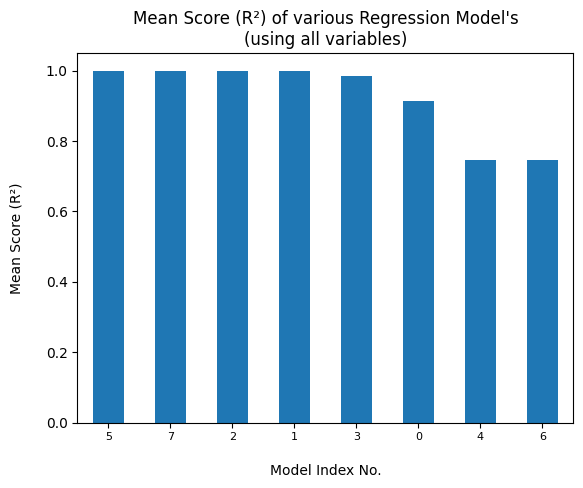

,estimator,min_score,mean_score (R²),max_score,std_score
5,RandomForestRegressor,0.997664,0.997743,0.997813,0.000052
7,XGBRegressor,0.997578,0.997652,0.997732,0.000059
2,ExtraTreesRegressor,0.99751,0.997609,0.997669,0.00006
1,DecisionTreeRegressor,0.997327,0.997464,0.997516,0.000069
3,GradientBoostingRegressor,0.982152,0.983226,0.984276,0.000744
0,AdaBoostRegressor,0.908245,0.9126,0.915833,0.002687
4,LinearRegression,0.745012,0.746857,0.750444,0.002034
6,SGDRegressor,0.745002,0.746738,0.750485,0.002029


In [14]:
# import matplotlib.pyplot as plt

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score (R²)')
results = grid_search_summary['mean_score (R²)']
results.plot(kind="bar",title="Mean Scores (R²)")

axes = plt.gca()
axes.set_ylim([0.0,1.05])
plt.xticks(rotation=0, fontsize=8)

plt.title("Mean Score (R²) of various Regression Model's\n(using all variables)")
plt.ylabel('Mean Score (R²)\n')
plt.xlabel('\nModel Index No.')
plt.show()
grid_search_summary

---

## Exclude Calculated Requirements
These are naturally be cross correlated to the base requirement they are calculated and may unduly skew the model.

In [15]:
df.head(3)

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,51,2.622251,1.159577,0.148056,55.524146,0.4,236.428943,1.025,58.6,2.622251,0.975116,0.24234,0.969359,36.6,99.56
1,51,3.888165,2.251012,0.811380,55.852018,0.5,236.428943,1.025,58.5,1.265914,1.091435,0.24234,1.211698,36.6,99.35
2,51,4.521122,3.159056,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.632957,0.908044,0.24234,1.454038,36.6,99.25


Re-Define the Pipeline

In [16]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Data_No', 'Differential_pressure',
                                                                'Flow_rate', 'Time', 'Dust_feed', 'Dust'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Re-Run hyperparameter optimization search using default hyperparameters **on less variables**.

In [17]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

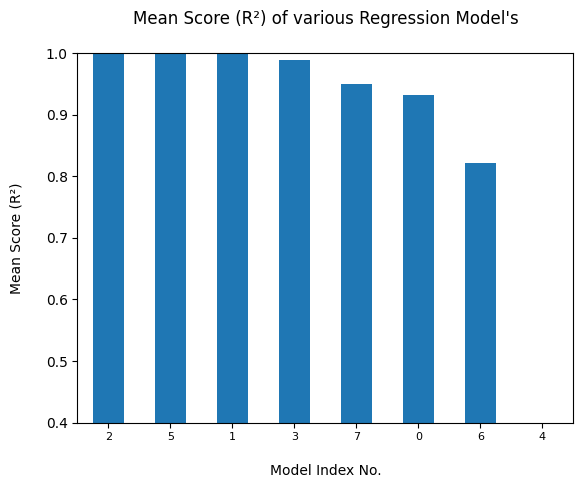

,estimator,min_score,mean_score (R²),max_score,std_score
2,ExtraTreesRegressor,0.998384,0.998527,0.998684,0.000097
5,RandomForestRegressor,0.998297,0.99841,0.998642,0.000126
1,DecisionTreeRegressor,0.997035,0.997842,0.998236,0.000425
3,GradientBoostingRegressor,0.987818,0.98932,0.990673,0.001033
7,XGBRegressor,0.947637,0.950102,0.951595,0.00167
0,AdaBoostRegressor,0.927983,0.931651,0.934335,0.002063
6,SGDRegressor,0.818188,0.821327,0.824427,0.00199
4,LinearRegression,0.256007,0.266865,0.277075,0.006768


In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score (R²)')
results = grid_search_summary['mean_score (R²)']
results.plot(kind="bar",title="Mean Scores (R²)")

axes = plt.gca()
axes.set_ylim([0,1.1])
plt.xticks(rotation=0, fontsize=8)

plt.title("Mean Score (R²) of various Regression Model's\n")
plt.ylabel('Mean Score (R²)\n')
plt.xlabel('\nModel Index No.')
plt.show()
grid_search_summary

### Observations
* The average **R² score** (mean_score) indicates how well a model of the data fits the actual data. It ranges from **0.45** to **0.95**, which is exceptional, as value of R² score = 1 represents a perfect fit.
* The R² score of most estimators is much higher than the **0.7** tolerance we decided in the business case.
    * We could use this information to feedback to the business team to review the business model.
    * A tolerance level between **0.85** to **0.95** may be suitable for this dataset / business case.


* From this quick review, we have a range of choices between most regressors. The best result is the **RandomForestRegressor Regressor** however any of the ExtraTree, DecisionTree or GradientBoosting regressors perform above the current business requirement tolerance.

* The GradientBoosting regressor under performs and would not be included for further consideration in this business case.

In [19]:
# stop

## Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

#### Random Forest Regressor (8min)

In [20]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

models_search = {
    'RandomForestRegressor': RandomForestRegressor(),
}

params_search = {
    'RandomForestRegressor':{
        # 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # 'model__criterion': ['squared_error', 'friedman_mse', 'poisson'],
        'model__criterion': ['poisson'],
        # # 'model__max_depth': [None],
        # 'model__max_depth': [3,10,None],
        'model__max_features': [1.0, 'sqrt', 'log2'],
        # 'model__n_estimators': [100,300,600,29089],
        'model__n_estimators': [100,400,800],
        # 'model__n_jobs': [None, 1],
        # 'model__n_jobs': [None],
    }
}

Extensive GridSearch CV

In [21]:
search_rfr = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_rfr.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/workspace/.pip-modules/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Check results

In [22]:
grid_search_summary, grid_search_pipelines = search_rfr.score_summary(sort_by='mean_score (R²)')
grid_search_summary

,estimator,min_score,mean_score (R²),max_score,std_score,model__criterion,model__max_features,model__n_estimators
1,RandomForestRegressor,0.998304,0.998476,0.99865,0.00013,poisson,1.0,400
2,RandomForestRegressor,0.998305,0.99842,0.998658,0.000128,poisson,1.0,800
0,RandomForestRegressor,0.998303,0.998412,0.998638,0.000122,poisson,1.0,100
6,RandomForestRegressor,0.998211,0.998278,0.998342,0.000054,poisson,log2,100
5,RandomForestRegressor,0.998015,0.998239,0.998359,0.000122,poisson,sqrt,800
8,RandomForestRegressor,0.998008,0.998235,0.99836,0.000124,poisson,log2,800
7,RandomForestRegressor,0.99799,0.998234,0.998364,0.000131,poisson,log2,400
4,RandomForestRegressor,0.997977,0.99823,0.998357,0.000136,poisson,sqrt,400
3,RandomForestRegressor,0.997902,0.998206,0.998343,0.000158,poisson,sqrt,100


---

#### Extra Trees Regressor (48min)

In [23]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

models_search = {
    'ExtraTreesRegressor': ExtraTreesRegressor(),
}

params_search = {
    'ExtraTreesRegressor':{
        'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # # 'model__max_depth': [None],
        # 'model__max_depth': [3,10,None],
        # 'model__max_features': [1.0, 'sqrt', 'log2'],
        # model__min_samples_split': [2,4,6],
        # 'model__n_estimators': [100,200,300],
        # 'model__n_jobs': [None, 1],
    }
}

Extensive GridSearch CV

In [24]:
# search_et = HyperparameterOptimizationSearch(models=models_search, params=params_search)
# search_et.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=2)

Check Results

In [25]:
# grid_search_summary_ExtraTrees, grid_search_pipelines_ExtraTrees = search_et.score_summary(sort_by='mean_score (R²)')
# grid_search_summary_ExtraTrees

Concatenation into a summary

In [26]:
# grid_search_summary = pd.concat([grid_search_summary_RForest, grid_search_summary_ExtraTrees], ignore_index=True)
# grid_search_pipelines = dict(grid_search_summary_RForest); grid_search_pipelines.update(grid_search_summary_ExtraTrees)

---

#### Check the best model

In [27]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Hyperparameters for best model

In [28]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__criterion': 'poisson',
 'model__max_features': 1.0,
 'model__n_estimators': 400}

Define the best regressor, based on search

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Data_No',
                                                     'Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed', 'Dust'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('model',
                 RandomForestRegressor(criterion='poisson', n_estimators=400))])

In [30]:
type(X_train)

pandas.core.frame.DataFrame

## Assess feature importance

Recall best Parameters

In [31]:
best_parameters

{'model__criterion': 'poisson',
 'model__max_features': 1.0,
 'model__n_estimators': 400}

Manually define these into the best model

In [32]:
rfr_model = RandomForestRegressor(
    criterion='poisson',
    max_features='log2',
    n_estimators=800,
    )
rfr_model.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_features='log2',
                      n_estimators=800)

Visualize results

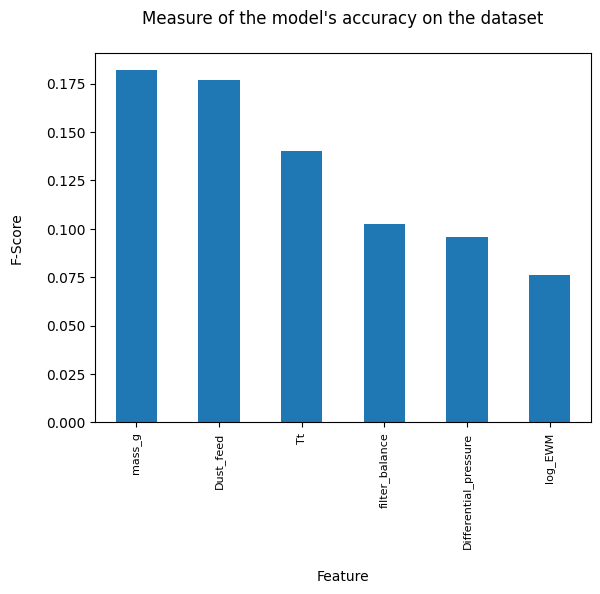

In [33]:
feat_importances = (pd.Series(rfr_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))
plt.xticks(fontsize=8)
plt.title("Measure of the model's accuracy on the dataset\n")
plt.ylabel("F-Score\n")
plt.xlabel('\nFeature')
plt.show()

#### Observations
dasfds...

---

## Evaluate Regressor Performance on Train and Test Sets

Compute a performance metric on the data held out for testing, **df_test**
* [R² score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) (also called Coefficient of Determination)
* [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (MAE)
* [Median Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html) (MdAE)
* [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE)
* Root Mean Squared Error (RMSE).

We could also consider:
* Almost Correct Predictions Error Rate (ACPER)
* Mean Absolute Percentage Error (MAPE) and 
* Adjusted R² Score 
    * _((1 - R²) * (sample_size - 1)) * -1 / (sample_size - no_independent_features - 1))_

Define Evaluation Functions

In [34]:
# from sklearn.metrics import (
#     r2_score, mean_squared_error, mean_absolute_error,
#     median_absolute_error
#     )
# import numpy as np
# import seaborn as sns

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Median Absolute Error:', median_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Run Performance Evaluation

Model Evaluation 

* Train Set
R2 Score: 0.999
Mean Absolute Error: 1.136
Median Absolute Error: 0.504
Mean Squared Error: 4.475
Root Mean Squared Error: 2.115


* Test Set
R2 Score: 0.998
Mean Absolute Error: 1.628
Median Absolute Error: 0.881
Mean Squared Error: 7.737
Root Mean Squared Error: 2.782




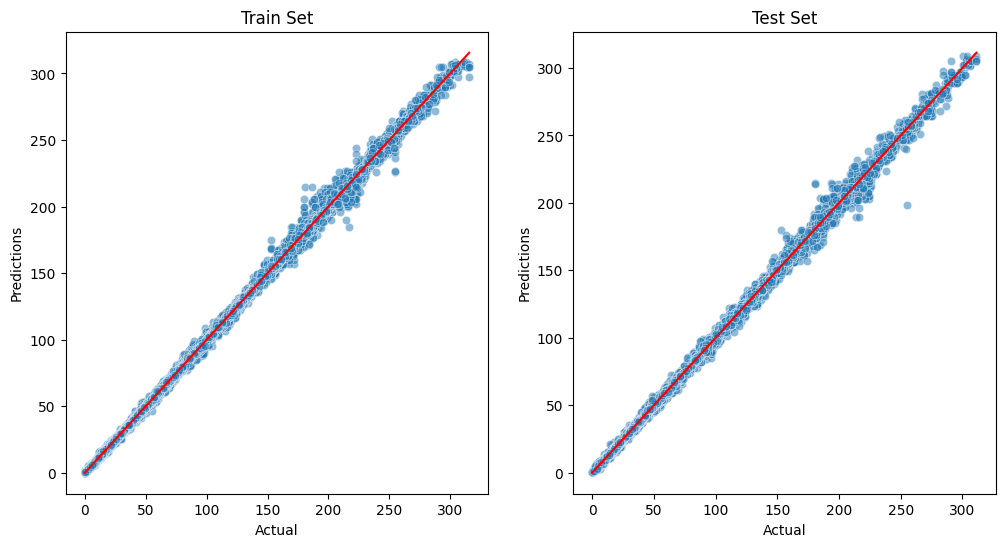

In [37]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

#### Observations
dasfds...


In [ ]:
stop

---

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [39]:
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor())])
pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)
print(f"RFR: {r2}") # RFR: 0.9998971254163361

RFR: 0.9998971254163361


In [ ]:
pipeline = PipelineOptimization(model=RandomForestRegressor(random_state=0))
pipeline_pca = Pipeline(pipeline.steps[:4])
# df_pca = pipeline_pca.fit_transform(df.drop(['Data_No'], axis=1))
df_pca = pipeline_pca.fit_transform(df))

In [40]:
# pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor(
#     criterion='poisson',
#     max_features='log2',
#     n_estimators=800,
#     max_depth=2,
#     random_state=0,
# ))])
# pipeline.fit(X_train, y_train)

# r2 = pipeline.score(X_test, y_test)
# print(f"RFR: {r2}") # 0.7289386100972868

RFR: 0.7289386100972868


Apply PCA separately to the scaled data

In [41]:
# import numpy as np
# import seaborn as sns
# from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


NameError: name 'df_pca' is not defined

In [ ]:
n_components = 5
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [ ]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [ ]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

### Use standard hyperparameters to find the most suitable model.

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

In [ ]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['tenure'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='tenure')
plt.show()

In [ ]:
df_clf.head(3)

## Rewrite ML Pipeline for Modelling

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [ ]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [ ]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


Extensive GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary


Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model
* We are saving this content for later

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

In [ ]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [ ]:
disc.binner_dict_['tenure']

We can create manually

In [ ]:
label_map = ['<4.0', '4.0 to 20.0','+20.0']
label_map

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [ ]:
pipeline_clf

# Refit pipeline with best features

## Rewrite Pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Contract', 'PaymentMethod'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


Subset Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [ ]:
models_search

And the best parameters from the previous GridCV search

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

In [ ]:
# params_search = {f'{models_search}': best_parameters}
# params_search

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [ ]:
label_map

In [ ]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

## Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---